Build a lightgbm classifier for the titanic set

Lightgbm has 4 different types of boosting,   gradient boost,  random forest, “dart” and “goss”-  find out what the last two methods are, and explain them.

Determine which seems to work best on the titanic data set

Optimize your model using hyperparameter search

Determine feature importance using the method built into lightgbm

Plot out the lightgbm tree produced by the best method you arrived at

In [132]:
import pandas as pd
titanicData = pd.read_csv("/content/titanic_train.csv")

In [133]:
titanicData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


###Lightgbm has 4 different types of boosting,   gradient boost,  random forest, “dart” and “goss”-  find out what the last two methods are, and explain them.

LightGBM’s Gradient-Based One-Side Sampling (GOSS):

Goss separtes the training data into two subsets: one with instances with significant gradients and another with examples having small gradients. Goss selectivly downsamples from the latter group as opposed to subsampling the entire dataset, which enables the model to concentrate on useful data points.

DART(Dropouts meet Multiple Additive Regression Trees)

Dart randomly eliminates a subset of trees. THis dropout procedure lessens overfitting and promotes the model to rely on a variety of poor learners. The predictions from several subsentes of trees are them combined by dart to produce a more dependable forcast.



#Determine which seems to work best on the titanic data set

In [134]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [135]:
y=titanicData['Survived']
titanicData = titanicData.drop(['Survived'], axis=1)

In [136]:
len(titanicData['Ticket'])

891

In [137]:
len(titanicData['Embarked'].unique())

4

### Going to get rid of name, passenger ID, Ticket as they are unique identifiers. I am Going to standarize fare to see if higher fare meant higher survival rates and one hot encode the "Embarked". Also get rid of cabin as some are missing and it would make no sense to impute them.


In [138]:
titanicData = titanicData.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

In [139]:
titanicData

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [140]:
stringTitanic = titanicData[['Sex','Embarked']]

In [141]:
titanicData['Pclass'].unique()

array([3, 1, 2])

In [142]:
titanicData['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

In [143]:
titanicData['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

In [144]:
noTrementTitanic = titanicData[['Parch','SibSp','Pclass']]

In [156]:
noTrementTitanic['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

In [157]:
noTrementTitanic['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

In [158]:
noTrementTitanic['Pclass'].unique()

array([3, 1, 2])

Yea no treatment needed

In [145]:
continuousTitanic = titanicData[['Fare','Age']]

In [146]:
continuousTitanic.isna()['Fare'].unique()

array([False])

In [147]:
continuousTitanic.isna()['Age'].unique()

array([False,  True])

In [148]:
# Impute the age with median age

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy="most_frequent")
stringTitanic= pd.DataFrame(imp.fit_transform(stringTitanic[['Sex','Embarked']]), columns = ['Sex','Embarked'])



impCont = SimpleImputer(strategy="median")
continuousTitanic= pd.DataFrame(impCont.fit_transform(continuousTitanic[["Age","Fare"]]), columns = ["Age","Fare"])



In [149]:
continuousTitanic.isna()['Age'].unique()

array([False])

In [150]:
#One hot encode the strings
from sklearn.preprocessing import OneHotEncoder

encode_titanic=OneHotEncoder()

titanic_fit1= encode_titanic.fit_transform(stringTitanic[stringTitanic.columns[0]].to_numpy().reshape(-1,1))
df_1_encoded=pd.DataFrame(titanic_fit1.toarray(),columns=encode_titanic.categories_[0][:])



titanic_fit2= encode_titanic.fit_transform(stringTitanic[stringTitanic.columns[1]].to_numpy().reshape(-1,1))
df_2_encoded=pd.DataFrame(titanic_fit2.toarray(),columns=encode_titanic.categories_[0][:])


In [151]:
df_1_encoded

,female,male
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0
...,...,...
886,0.0,1.0
887,1.0,0.0
888,1.0,0.0
889,0.0,1.0


In [152]:
df_2_encoded

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
886,0.0,0.0,1.0
887,0.0,0.0,1.0
888,0.0,0.0,1.0
889,1.0,0.0,0.0


In [153]:
#Standardization
scaler = StandardScaler()

continuousTitanicHolder = scaler.fit_transform(continuousTitanic)

In [154]:
continuousTitanic

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500
...,...,...
886,27.0,13.0000
887,19.0,30.0000
888,28.0,23.4500
889,26.0,30.0000


In [155]:
continuousTitanic=pd.DataFrame(continuousTitanicHolder,columns=continuousTitanic.columns)
continuousTitanic

,Age,Fare
0,-0.565736,-0.502445
1,0.663861,0.786845
2,-0.258337,-0.488854
3,0.433312,0.420730
4,0.433312,-0.486337
...,...,...
886,-0.181487,-0.386671
887,-0.796286,-0.044381
888,-0.104637,-0.176263
889,-0.258337,-0.044381


In [159]:
Titanic_final = pd.concat([continuousTitanic,df_2_encoded,df_1_encoded,noTrementTitanic],axis=1)

In [160]:
Titanic_final

,Age,Fare,C,Q,S,female,male,Parch,SibSp,Pclass
0,-0.565736,-0.502445,0.0,0.0,1.0,0.0,1.0,0,1,3
1,0.663861,0.786845,1.0,0.0,0.0,1.0,0.0,0,1,1
2,-0.258337,-0.488854,0.0,0.0,1.0,1.0,0.0,0,0,3
3,0.433312,0.420730,0.0,0.0,1.0,1.0,0.0,0,1,1
4,0.433312,-0.486337,0.0,0.0,1.0,0.0,1.0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
886,-0.181487,-0.386671,0.0,0.0,1.0,0.0,1.0,0,0,2
887,-0.796286,-0.044381,0.0,0.0,1.0,1.0,0.0,0,0,1
888,-0.104637,-0.176263,0.0,0.0,1.0,1.0,0.0,2,1,3
889,-0.258337,-0.044381,1.0,0.0,0.0,0.0,1.0,0,0,1


In [161]:
y.unique()

array([0, 1])

In [162]:
X_train, X_test, y_train, y_test = train_test_split(Titanic_final, y, test_size=0.2, random_state=42)


In [188]:
#gradient boost

train_data = lgb.Dataset(X_train, label=y_train)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'num_leaves': 11,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the GBDT model
gbm = lgb.train(params, train_data, num_boost_round=100)

# Make predictions on the test set
y_pred = gbm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
print("Accuracy:", accuracy)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
Accuracy: 0.8100558659217877


0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [180]:
#GOSS

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
# ... (Data loading and splitting as in GBDT example)

# Define parameters for GOSS
params = {
    'objective': 'binary',
    'boosting_type': 'goss',
    'metric': 'binary_logloss',
    'num_leaves': 3,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the GOSS model
gbm_goss = lgb.train(params, train_data, num_boost_round=100)

# Make predictions on the test set
y_pred_goss = gbm_goss.predict(X_test)

# Evaluate the model
accuracy_goss = accuracy_score(y_test, (y_pred_goss > 0.5).astype(int))
print("Accuracy (GOSS):", accuracy_goss)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.5

In [181]:
#Dart

params = {
    'objective': 'binary',
    'boosting_type': 'dart',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
}

# Train the DART model
gbm_dart = lgb.train(params, train_data, num_boost_round=100)

# Make predictions on the test set
y_pred_dart = gbm_dart.predict(X_test)

# Evaluate the model
accuracy_dart = accuracy_score(y_test, (y_pred_dart > 0.5).astype(int))
print("Accuracy (DART):", accuracy_dart)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [187]:
#Random Forest.

train_data = lgb.Dataset(X_train, label=y_train)

# Define parameters for GBDT
params = {
    'objective': 'binary',
    'boosting_type': 'rf',
    'metric': 'binary_logloss',
    'num_leaves': 11,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the GBDT model
gbm_rf = lgb.train(params, train_data, num_boost_round=100)

# Make predictions on the test set
y_pred = gbm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
print("Accuracy:", accuracy)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
Accuracy: 0.8100558659217877


gradient boost slightly better than DART

###Optimize your model using hyperparameter search



In [185]:
## Grid search the hyperparameter values
from sklearn.model_selection import GridSearchCV
#gradient boost

# Define parameters grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [10, 20, 30]
}

# Initialize LightGBM regressor
lgb_reg = lgb.LGBMRegressor()

# Perform grid search
grid_search = GridSearchCV(estimator=lgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (negative mean squared error):", best_score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] Start training from score 0.372583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] Start training from score 0.376098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

#Determine feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

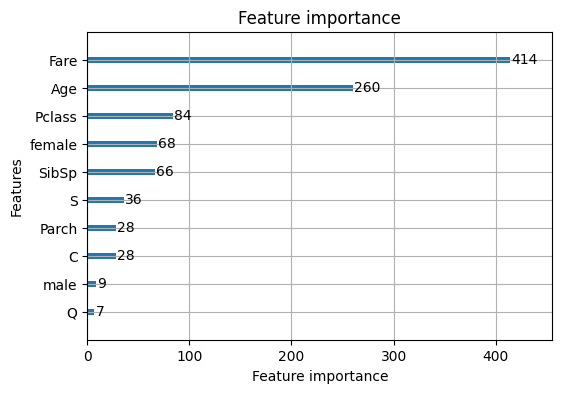

In [190]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))
lgb.plot_importance(gbm, ax=ax)


Fare seems to be the most important feature

#Plot out the lightgbm tree produced by the best method you arrived at

<Axes: >

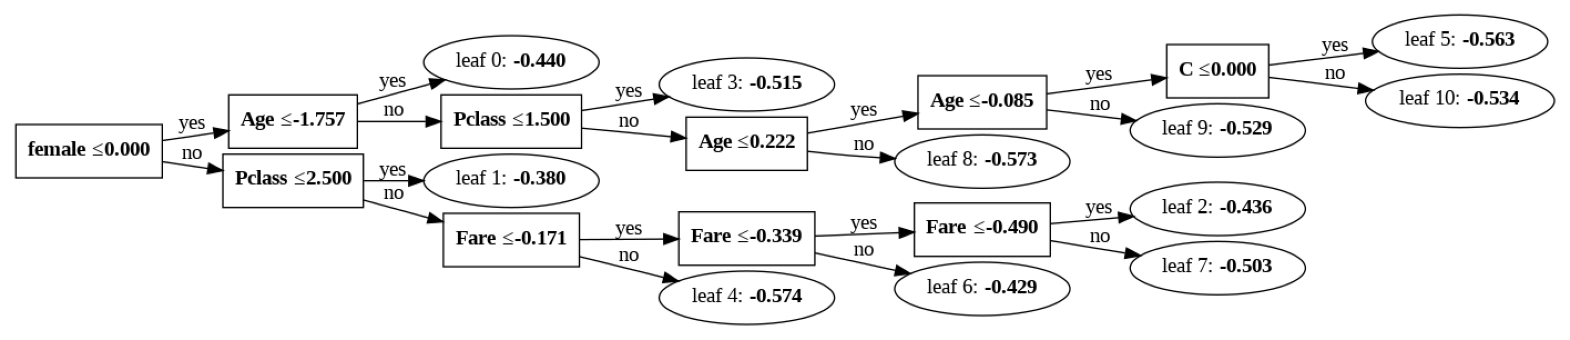

In [195]:
fig, ax = plt.subplots(figsize=(20, 20))
lgb.plot_tree(gbm, tree_index=0, ax=ax)